# Google Colab setup with Google Drive folder

This notebook provides the code you need to set up Google Colab to run and import files from within a Google Drive folder.

This will allow you to upload assignment code to your Google Drive and then run the code on Google Colab machines (with free GPUs if needed).

You will need to create a folder in your Google Drive to hold your assignments and you will need to open Colaboratory within this folder before running the set up code (check the link above to see how).

# Mount Google Drive

This will allow the Colab machine to access Google Drive folders by mounting the drive on the machine. You will be asked to copy and paste an authentication code.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
ls

gdrive/  sample_data/


# Change directory to allow imports


As noted above, you should create a Google Drive folder to hold all your assignment files. You will need to add this code to the top of any python notebook you run to be able to import python files from your drive assignment folder (you should change the file path below to be your own assignment folder). Following the hand-out, you should have a directory "SFU_CMPT_CV_lab2" on g-drive, which should have a directory "data", which contains three tar.gz files.

In [5]:
import os
os.chdir("/content/gdrive/My Drive/SFU_CMPT_CV_lab2")

In [6]:
ls # Check if this is your folder

best_model.pth  data/  FMix/  lab2.ipynb  plot.png  submission_netid.csv


# Copy data to local dir

In [7]:
!mkdir /data
!cp data/cifar100.tar.gz /data/
!tar -xf /data/cifar100.tar.gz -C /data/
!cp data/test.tar.gz /data
!tar -xf /data/test.tar.gz -C /data
!cp data/train.tar.gz /data
!tar -xf /data/train.tar.gz -C /data/

In [8]:
ls /data

cifar100/  cifar100.tar.gz  test/  test.tar.gz  train/  train.tar.gz


# Set up GPU and PyTorch

First, ensure that your notebook on Colaboratory is set up to use GPU. After opening the notebook on Colaboratory, go to Edit>Notebook settings, select Python 3 under "Runtime type," select GPU under "Hardware accelerator," and save.

Next, install PyTorch:

In [9]:
!pip3 install torch torchvision

Make sure that pytorch is installed and works with GPU:

In [10]:
import torch
a = torch.Tensor([1]).cuda()
print(a)


tensor([1.], device='cuda:0')


In [11]:
torch.cuda.is_available()

True

# Part 1

In [ ]:
!rm -rf FMix


In [ ]:
# Step 1: Clone the repository
!git clone https://github.com/ecs-vlc/FMix.git

# Step 2: Append the repository path to sys.path
import sys
sys.path.append("/content/FMix")
# from fmix import sample_and_apply, sample_mask


Cloning into 'FMix'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 251 (delta 13), reused 11 (delta 4), pack-reused 221
Receiving objects: 100% (251/251), 1.14 MiB | 14.12 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [ ]:
%cd FMix
!ls



/content/gdrive/MyDrive/SFU_CMPT_CV_lab2/FMix
analysis     fmix_example.png  LICENSE	  __pycache__		trainer.py
datasets     fmix.py	       models	  README.md		utils
experiments  hubconf.py        notebooks  requirements.txt
fmix_3d.gif  implementations   plot.png   submission_netid.csv


In [ ]:
from fmix import sample_and_apply, sample_mask
%cd ..

/content/gdrive/MyDrive/SFU_CMPT_CV_lab2


In [12]:
"""Headers"""

from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity

import csv
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path
import sys
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from torch.optim.lr_scheduler import StepLR

np.random.seed(111)
torch.cuda.manual_seed_all(111)
torch.manual_seed(111)

# from FMIX.fmix import sample_and_apply, sample_mask



## **Just execute the cell below. This is the dataloader. DO NOT CHANGE ANYTHING IN HERE!**


In [13]:
""""""

class CIFAR10_SFU_CV(data.Dataset):
    """`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """
    base_folder = 'cifar100'
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar100.tar.gz"
    tgz_md5 = 'c58f30108f718f92721af3b95e74349a'
    train_list = [
        ['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
        ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
        ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
        ['data_batch_4', '634d18415352ddfa80567beed471001a'],
        ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb'],
    ]

    test_list = [
        ['test_batch', '40351d587109b95175f43aff81a1287e'],
    ]

    def __init__(self, root, fold="train",
                 transform=None, target_transform=None,
                 download=False):

        fold = fold.lower()

        self.train = False
        self.test = False
        self.val = False

        if fold == "train":
            self.train = True
        elif fold == "test":
            self.test = True
        elif fold == "val":
            self.val = True
        else:
            raise RuntimeError("Not train-val-test")


        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform

        fpath = os.path.join(root, self.filename)
        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' Download it and extract the file again.')

        # now load the picked numpy arrays
        if self.train or self.val:
            self.train_data = []
            self.train_labels = []
            for fentry in self.train_list:
                f = fentry[0]
                file = os.path.join(self.root, self.base_folder, f)
                fo = open(file, 'rb')
                if sys.version_info[0] == 2:
                    entry = pickle.load(fo)
                else:
                    entry = pickle.load(fo, encoding='latin1')
                self.train_data.append(entry['data'])
                if 'labels' in entry:
                    self.train_labels += entry['labels']
                else:
                    self.train_labels += entry['fine_labels']
                fo.close()

            self.train_data = np.concatenate(self.train_data)
            self.train_data = self.train_data.reshape((50000, 3, 32, 32))
            self.train_data = self.train_data.transpose((0, 2, 3, 1))  # convert to HWC

            p = np.arange(0,50000,10)
            mask_train = np.ones((50000,), dtype=bool)
            mask_train[p] = False
            mask_val = np.zeros((50000,), dtype=bool)
            mask_val[p] = True

            copy_all_data = np.array(self.train_data)
            self.val_data = np.array(copy_all_data[mask_val])
            self.train_data = np.array(copy_all_data[mask_train])

            copy_all_labels = np.array(self.train_labels)
            self.val_labels = np.array(copy_all_labels[mask_val])
            self.train_labels = np.array(copy_all_labels[mask_train])

        elif self.test:
            f = self.test_list[0][0]
            file = os.path.join(self.root, self.base_folder, f)
            fo = open(file, 'rb')
            if sys.version_info[0] == 2:
                entry = pickle.load(fo)
            else:
                entry = pickle.load(fo, encoding='latin1')
            self.test_data = entry['data']

            if 'labels' in entry:
                self.test_labels = entry['labels']
            else:
                self.test_labels = entry['fine_labels']
            fo.close()
            self.test_data = self.test_data.reshape((10000, 3, 32, 32))
            self.test_data = self.test_data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        elif self.test:
            img, target = self.test_data[index], self.test_labels[index]
        elif self.val:
            img, target = self.val_data[index], self.val_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        elif self.test:
            return len(self.test_data)
        elif self.val:
            return len(self.val_data)

    def _check_integrity(self):
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


class CIFAR100_SFU_CV(CIFAR10_SFU_CV):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar100'
    filename = "cifar100.tar.gz"
    tgz_md5 = 'e68a4c763591787a0b39fe2209371f32'
    train_list = [
        ['train_cs543', '49eee854445c1e2ebe796cd93c20bb0f'],
    ]

    test_list = [
        ['test_cs543', 'd3fe9f6a9251bd443f428f896d27384f'],
    ]

This file has been adapted from the easy-to-use tutorial released by PyTorch:
http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Training an image classifier
----------------------------

We will do the following steps in order:

1. Load the CIFAR100_SFU_CV training, validation and test datasets using
   torchvision. Use torchvision.transforms to apply transforms on the
   dataset.
2. Define a Convolution Neural Network - BaseNet
3. Define a loss function and optimizer
4. Train the network on training data and check performance on val set.
   Plot train loss and validation accuracies.
5. Try the network on test data and create .csv file for submission to kaggle

In [14]:
# <<TODO#5>> Based on the val set performance, decide how many
# epochs are apt for your model.
# ---------
EPOCHS = 200
# ---------

IS_GPU = True
TEST_BS = 256
TOTAL_CLASSES = 100
TRAIN_BS = 32
PATH_TO_CIFAR100_SFU_CV = "/data/"

In [15]:
ls /data/cifar100/

test_cs543  train_cs543


In [16]:
#eric
def calculate_val_accuracy(valloader, is_gpu):
  """ Util function to calculate val set accuracy,
  both overall and per class accuracy
  Args:
  valloader (torch.utils.data.DataLoader): val set
  is_gpu (bool): whether to run on GPU
  Returns:
  tuple: (overall accuracy, class level accuracy)
  """
  correct = 0.
  total = 0.
  predictions = []

  class_correct = list(0. for i in range(TOTAL_CLASSES))
  class_total = list(0. for i in range(TOTAL_CLASSES))

  for data in valloader:
    images, labels = data
    if is_gpu:
      images = images.cuda()
      labels = labels.cuda()
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(list(predicted.cpu().numpy()))
    total += labels.size(0)
    # The following line reported an error for some students. Put a new version.
    # correct += (predicted == labels).sum()
    correct += torch.sum(predicted == labels).detach().cpu().numpy()

    # The following line reported an error for some students. Put a new version.
    # c = (predicted == labels).squeeze()
    c = torch.squeeze(predicted == labels).detach().cpu().numpy()
    # Added for a fix.
    # c = c.cpu()
    for i in range(len(labels)):
      label = labels[i]
      class_correct[label] += c[i]
      class_total[label] += 1

  class_accuracy = 100 * np.divide(class_correct, class_total)
  return 100*correct/total, class_accuracy


In [ ]:
def calculate_val_accuracy(valloader, is_gpu):
    """ Util function to calculate val set accuracy,
    both overall and per class accuracy
    Args:
        valloader (torch.utils.data.DataLoader): val set
        is_gpu (bool): whether to run on GPU
    Returns:
        tuple: (overall accuracy, class level accuracy)
    """
    correct = 0.
    total = 0.
    predictions = []

    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))

    for data in valloader:
        images, labels = data
        if is_gpu:
            images = images.cuda()
            labels = labels.cuda()
        outputs = model(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(list(predicted.cpu().numpy()))
        total += labels.size(0)
        # The following line reported an error for some students. Put a new version.
        # correct += (predicted == labels).sum()
        correct += torch.sum(predicted == labels).detach().cpu().numpy()

        # The following line reported an error for some students. Put a new version.
        # c = (predicted == labels).squeeze()
        c = torch.squeeze(predicted == labels).detach().cpu().numpy()
        # Added for a fix.
        # c = c.cpu()

        c = torch.squeeze(predicted == labels).detach().cpu().numpy()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    class_accuracy = 100 * np.divide(class_correct, class_total)
    return 100*correct/total, class_accuracy

1.** Loading CIFAR100_SFU_CV**

We modify the dataset to create CIFAR100_SFU_CV dataset which consist of 45000 training images (450 of each class), 5000 validation images (50 of each class) and 10000 test images (100 of each class). The train and val datasets have labels while all the labels in the test set are set to 0.


In [17]:
train = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="train", download=True, transform=transforms.ToTensor())
val = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="val", download=True, transform=transforms.ToTensor())
test = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="test", download=True, transform=transforms.ToTensor())

combined = torch.utils.data.ConcatDataset([train, val, test])

imgs = [item[0] for item in combined]
imgs = torch.stack(imgs, dim=0).numpy()

# calculate mean
print("Mean \t", imgs[:,0,:,:].mean(), imgs[:,1,:,:].mean(), imgs[:,2,:,:].mean())

# calculate std
print("STD:\t", imgs[:,0,:,:].std(), imgs[:,1,:,:].std(), imgs[:,2,:,:].std())

Mean 	 0.5073615 0.48668912 0.4410893
STD:	 0.26748818 0.2565931 0.27630857


In [20]:
# eric
# The output of torchvision datasets are PILImage images of range [0, 1].
# Using transforms.ToTensor(), transform them to Tensors of normalized range
# [-1, 1].


# <<TODO#1>> Use transforms.Normalize() with the right parameters to
# make the data well conditioned (zero mean, std dev=1) for improved training.
# <<TODO#2>> Try using transforms.RandomCrop() and/or transforms.RandomHorizontalFlip()
# to augment training data.
# After your edits, make sure that test_transform should have the same data
# normalization parameters as train_transform
# You shouldn't have any data augmentation in test_transform (val or test data is never augmented).
# ---------------------

train_transform = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5073615, 0.48668912, 0.4410893],
                          std=[0.26748818, 0.2565931, 0.27630857]),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip()
])

# For test/validation data:
# First, we convert the image to a tensor.
# Lastly, we normalize the data (no augmentation for test/validation data).
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5073615, 0.48668912, 0.4410893],
                          std=[0.26748818, 0.2565931, 0.27630857])
])

# ---------------------

trainset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="train",
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BS,
                                          shuffle=True, num_workers=0)
print("Train set size: "+str(len(trainset)))

valset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="val",
                                       download=True, transform=test_transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=TEST_BS,
                                         shuffle=False, num_workers=0)
print("Val set size: "+str(len(valset)))

testset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="test",
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=TEST_BS,
                                         shuffle=False, num_workers=0)
print("Test set size: "+str(len(testset)))

# The 100 classes for CIFAR100
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']



Train set size: 45000
Val set size: 5000
Test set size: 10000


In [19]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# Using transforms.ToTensor(), transform them to Tensors of normalized range
# [-1, 1].


# <<TODO#1>> Use transforms.Normalize() with the right parameters to
# make the data well conditioned (zero mean, std dev=1) for improved training.
# <<TODO#2>> Try using transforms.RandomCrop() and/or transforms.RandomHorizontalFlip()
# to augment training data.
# After your edits, make sure that test_transform should have the same data
# normalization parameters as train_transform
# You shouldn't have any data augmentation in test_transform (val or test data is never augmented).
# ---------------------

# train_transform = transforms.Compose(
#     [transforms.ToTensor()])
# test_transform = transforms.Compose(
#     [transforms.ToTensor()])

mean = [0, 0, 0]
std = [1, 1, 1]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomRotation(15),
    # transforms.RandomCrop(28),
    # transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# ---------------------

trainset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="train",
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BS,
                                          shuffle=True, num_workers=2)
print("Train set size: "+str(len(trainset)))

valset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="val",
                                       download=True, transform=test_transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=TEST_BS,
                                         shuffle=False, num_workers=2)
print("Val set size: "+str(len(valset)))

testset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="test",
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=TEST_BS,
                                         shuffle=False, num_workers=2)
print("Test set size: "+str(len(testset)))

# The 100 classes for CIFAR100
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']



Train set size: 45000
Val set size: 5000
Test set size: 10000


In [ ]:
# 备份1
########################################################################
# 2. Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# We provide a basic network that you should understand, run and
# eventually improve
# <<TODO>> Add more conv layers
# <<TODO>> Add more fully connected (fc) layers
# <<TODO>> Add regularization layers like Batchnorm.
#          nn.BatchNorm2d after conv layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm2d
#          nn.BatchNorm1d after fc layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm1d
# This is a good resource for developing a CNN for classification:
# http://cs231n.github.io/convolutional-networks/#layers

import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(x)
        out = F.relu(out)
        return out


class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()

        # <<TODO#3>> Add more conv layers with increasing
        # output channels
        # <<TODO#4>> Add normalization layers after conv
        # layers (nn.BatchNorm2d)

        # Also experiment with kernel size in conv2d layers (say 3
        # inspired from VGGNet)
        # To keep it simple, keep the same kernel size
        # (right now set to 5) in all conv layers.
        # Do not have a maxpool layer after every conv layer in your
        # deeper network as it leads to too much loss of information.

        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)

        # First block of conv layers
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)  # Pooling layer

        # Second block of conv layers
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)


        # Third block of conv layers
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)  # Pooling layer

        # Forth block of conv layers
        self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)

        self.res_block1 = ResidualBlock(512, 512)
        self.res_block2 = ResidualBlock(512, 512)  # 新添加的残差块
        self.res_block3 = ResidualBlock(512, 512)  # 新添加的残差块

        # <<TODO#3>> Add more linear (fc) layers
        # <<TODO#4>> Add normalization layers after linear and
        # experiment inserting them before or after ReLU (nn.BatchNorm1d)
        # More on nn.sequential:
        # http://pytorch.org/docs/master/nn.html#torch.nn.Sequential

        # Adding Dropout
        self.dropout = nn.Dropout(p=0.5)

        # self.fc_net = nn.Sequential(
        #     nn.Linear(16 * 5 * 5, TOTAL_CLASSES//2),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(TOTAL_CLASSES//2, TOTAL_CLASSES),
        # )

        self.fc_net = nn.Sequential(
              nn.Linear(512 * 8 * 8, 8192),  # Modified the size here
              nn.BatchNorm1d(8192),
              nn.ReLU(inplace=True),
              self.dropout,

              nn.Linear(8192, 4096),
              nn.BatchNorm1d(4096),
              nn.ReLU(inplace=True),


              nn.Linear(4096, 2048),
              nn.BatchNorm1d(2048),
              nn.ReLU(inplace=True),
              self.dropout,

              nn.Linear(2048, 1024),
              nn.BatchNorm1d(1024),
              nn.ReLU(inplace=True),
              # self.dropout,



              # nn.Linear(1024, 512),
              # nn.BatchNorm1d(512),
              # nn.ReLU(inplace=True),

              # nn.Linear(512, 256),
              # nn.BatchNorm1d(256),
              # nn.ReLU(inplace=True),

              nn.Linear(1024, TOTAL_CLASSES//2),
              nn.BatchNorm1d(TOTAL_CLASSES//2),
              nn.ReLU(inplace=True),

              nn.Linear(TOTAL_CLASSES//2, TOTAL_CLASSES),
        )


    # def forward(self, x):

    #     # <<TODO#3&#4>> Based on the above edits, you'll have
    #     # to edit the forward pass description here.

    #     x = self.pool(F.relu(self.conv1(x)))
    #     # Output size = 28//2 x 28//2 = 14 x 14

    #     x = self.pool(F.relu(self.conv2(x)))
    #     # Output size = 10//2 x 10//2 = 5 x 5

    #     # See the CS231 link to understand why this is 16*5*5!
    #     # This will help you design your own deeper network
    #     x = x.view(-1, 16 * 5 * 5)
    #     x = self.fc_net(x)

    #     # No softmax is needed as the loss function in step 3
    #     # takes care of that

    #     return x
    def forward(self, x):
          # First block of conv layers
          x = F.relu(self.bn1(self.conv1(x)))
          x = self.pool1(F.relu(self.bn2(self.conv2(x))))  # 使用pool1代替pool
          # After this, if the input image is 32x32, the output size will be 16x16.

          # Second block of conv layers
          x = F.relu(self.bn3(self.conv3(x)))
          x = F.relu(self.bn4(self.conv4(x)))

          # Third block of conv layers
          x = F.relu(self.bn5(self.conv5(x)))
          x = self.pool2(F.relu(self.bn6(self.conv6(x))))# 使用pool2代替之前的pool
          # After this, the size will be 8x8

          # Forth block of conv layers
          x = F.relu(self.bn7(self.conv7(x)))
          x = F.relu(self.bn8(self.conv8(x)))

          x = self.res_block1(x) # Using the residual block
          x = self.res_block2(x)
          x = self.res_block3(x)

          # Flatten x before passing to fc layers
          x = x.view(-1, 512 * 8 * 8)

          # Pass x through the fc layers
          x = self.fc_net(x)

          return x




# Create an instance of the nn.module class defined above:
net = BaseNet()

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()


In [ ]:
########################################################################
# 2. Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# We provide a basic network that you should understand, run and
# eventually improve
# <<TODO>> Add more conv layers
# <<TODO>> Add more fully connected (fc) layers
# <<TODO>> Add regularization layers like Batchnorm.
#          nn.BatchNorm2d after conv layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm2d
#          nn.BatchNorm1d after fc layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm1d
# This is a good resource for developing a CNN for classification:
# http://cs231n.github.io/convolutional-networks/#layers

import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(x)
        out = F.relu(out)
        return out


class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()

        # <<TODO#3>> Add more conv layers with increasing
        # output channels
        # <<TODO#4>> Add normalization layers after conv
        # layers (nn.BatchNorm2d)

        # Also experiment with kernel size in conv2d layers (say 3
        # inspired from VGGNet)
        # To keep it simple, keep the same kernel size
        # (right now set to 5) in all conv layers.
        # Do not have a maxpool layer after every conv layer in your
        # deeper network as it leads to too much loss of information.

        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)

        # 1
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.r1 = nn.ReLU(inplace = True)
        #2
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.r2 = nn.ReLU(inplace = True)
        self.pool1 = nn.MaxPool2d(2, 2)  # Pooling layer

        #s1
        self.conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.r3 = nn.ReLU(inplace = True)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.r4 = nn.ReLU(inplace = True)

        #3
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.r5 = nn.ReLU(inplace = True)
        self.pool2 = nn.MaxPool2d(2, 2)  # Pooling layer
        #4
        self.conv6 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.r6 = nn.ReLU(inplace = True)
        self.pool3 = nn.MaxPool2d(2, 2)  # Pooling layer

        #s2
        self.conv7 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.r7 = nn.ReLU(inplace = True)

        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.r8 = nn.ReLU(inplace = True)

        #5
        self.conv9 = nn.Conv2d(512, 1028, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(1028)
        self.r9 = nn.ReLU(inplace = True)
        self.pool4 = nn.MaxPool2d(2, 2)  # Pooling layer

        #s3
        self.conv10 = nn.Conv2d(1028, 1028, 3, padding=1)
        self.bn10 = nn.BatchNorm2d(1028)
        self.r10 = nn.ReLU(inplace = True)

        self.conv11 = nn.Conv2d(1028, 1028, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(1028)
        self.r11 = nn.ReLU(inplace = True)


        # test if needed
        self.res_block1 = ResidualBlock(1028, 1028)
        self.res_block2 = ResidualBlock(1028, 1028)  # 新添加的残差块
        # self.res_block3 = ResidualBlock(1028, 1028)  # 新添加的残差块

        # <<TODO#3>> Add more linear (fc) layers
        # <<TODO#4>> Add normalization layers after linear and
        # experiment inserting them before or after ReLU (nn.BatchNorm1d)
        # More on nn.sequential:
        # http://pytorch.org/docs/master/nn.html#torch.nn.Sequential

        # Adding Dropout
        self.dropout = nn.Dropout(p=0.5)

        # self.fc_net = nn.Sequential(
        #     nn.Linear(16 * 5 * 5, TOTAL_CLASSES//2),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(TOTAL_CLASSES//2, TOTAL_CLASSES),
        # )

        self.fc_net = nn.Sequential(
              nn.Linear(1028 * 2 * 2, 4112),  # Modified the size here
              nn.BatchNorm1d(4112),
              nn.ReLU(inplace=True),
              self.dropout,

              # nn.Linear(8192, 4096),
              # nn.BatchNorm1d(4096),
              # nn.ReLU(inplace=True),


              nn.Linear(4112, 2048),
              nn.BatchNorm1d(2048),
              nn.ReLU(inplace=True),
              self.dropout,

              nn.Linear(2048, 1024),
              nn.BatchNorm1d(1024),
              nn.ReLU(inplace=True),
              # self.dropout,



              # nn.Linear(1024, 512),
              # nn.BatchNorm1d(512),
              # nn.ReLU(inplace=True),

              # nn.Linear(512, 256),
              # nn.BatchNorm1d(256),
              # nn.ReLU(inplace=True),

              nn.Linear(1024, TOTAL_CLASSES//2),
              nn.BatchNorm1d(TOTAL_CLASSES//2),
              nn.ReLU(inplace=True),

              nn.Linear(TOTAL_CLASSES//2, TOTAL_CLASSES),
        )


    # def forward(self, x):

    #     # <<TODO#3&#4>> Based on the above edits, you'll have
    #     # to edit the forward pass description here.

    #     x = self.pool(F.relu(self.conv1(x)))
    #     # Output size = 28//2 x 28//2 = 14 x 14

    #     x = self.pool(F.relu(self.conv2(x)))
    #     # Output size = 10//2 x 10//2 = 5 x 5

    #     # See the CS231 link to understand why this is 16*5*5!
    #     # This will help you design your own deeper network
    #     x = x.view(-1, 16 * 5 * 5)
    #     x = self.fc_net(x)

    #     # No softmax is needed as the loss function in step 3
    #     # takes care of that

    #     return x
    def forward(self, x):
          x = self.r1(self.bn1(self.conv1(x)))
          x = self.pool1(self.r2(self.bn2(self.conv2(x))))

          x = self.r3(self.bn4(self.conv4(self.r3(self.bn3(self.conv3(x)))))) + x

          x = self.pool2(self.r5(self.bn5(self.conv5(x))))
          x = self.pool3(self.r6(self.bn6(self.conv6(x))))

          x = F.relu(self.bn7(self.conv7(x)))
          x = F.relu(self.bn8(self.conv8(x)))

          x = self.r8(self.bn8(self.conv8(self.r7(self.bn7(self.conv7(x)))))) + x

          x = self.pool4(self.r9(self.bn9(self.conv9(x))))

          x = self.r11(self.bn11(self.conv11(self.r10(self.bn10(self.conv10(x)))))) + x

          x = self.res_block1(x) # Using the residual block
          x = self.res_block2(x)
          # x = self.res_block3(x)

          # Flatten x before passing to fc layers
          x = x.view(-1, 1028 * 2 * 2)

          # Pass x through the fc layers
          x = self.fc_net(x)

          return x




# Create an instance of the nn.module class defined above:
net = BaseNet()

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()


In [20]:
# csdn
########################################################################
# 2. Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# We provide a basic network that you should understand, run and
# eventually improve
# <<TODO>> Add more conv layers
# <<TODO>> Add more fully connected (fc) layers
# <<TODO>> Add regularization layers like Batchnorm.
#          nn.BatchNorm2d after conv layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm2d
#          nn.BatchNorm1d after fc layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm1d
# This is a good resource for developing a CNN for classification:
# http://cs231n.github.io/convolutional-networks/#layers

import torch.nn as nn
import torch.nn.functional as F
import math
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth, TOTAL_CLASSES, widen_factor=1, dropRate=0.0, nc=1):
        super(WideResNet, self).__init__()
        nChannels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert (depth - 4) % 6 == 0, 'depth should be 6n+4'
        n = (depth - 4) // 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(nc, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], TOTAL_CLASSES)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 7)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

def wrn(**kwargs):
    """
    Constructs a Wide Residual Networks.
    """
    model = WideResNet(**kwargs)
    return model

def smooth_step(a,b,c,d,x):
    level_s=0.01
    level_m=0.1
    level_n=0.01
    level_r=0.005
    if x<=a:
        return level_s
    if a<x<=b:
        return (((x-a)/(b-a))*(level_m-level_s)+level_s)
    if b<x<=c:
        return level_m
    if c<x<=d:
        return level_n
    if d<x:
        return level_r
# In[1] 设置一个通过优化器更新学习率的函数
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super(ResidualBlock, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
#         self.bn2 = nn.BatchNorm2d(out_channels)

#         self.skip = nn.Sequential()
#         if stride != 1 or in_channels != out_channels:
#             self.skip = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, 1, stride=stride),
#                 nn.BatchNorm2d(out_channels)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.skip(x)
#         out = F.relu(out)
#         return out


# class BaseNet(nn.Module):
#     def __init__(self):
#         super(BaseNet, self).__init__()

#         # <<TODO#3>> Add more conv layers with increasing
#         # output channels
#         # <<TODO#4>> Add normalization layers after conv
#         # layers (nn.BatchNorm2d)

#         # Also experiment with kernel size in conv2d layers (say 3
#         # inspired from VGGNet)
#         # To keep it simple, keep the same kernel size
#         # (right now set to 5) in all conv layers.
#         # Do not have a maxpool layer after every conv layer in your
#         # deeper network as it leads to too much loss of information.

#         # self.conv1 = nn.Conv2d(3, 6, 5)
#         # self.pool = nn.MaxPool2d(2, 2)
#         # self.conv2 = nn.Conv2d(6, 16, 5)

#         # First block of conv layers
#         self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
#         self.bn1 = nn.BatchNorm2d(8)
#         self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
#         self.bn2 = nn.BatchNorm2d(16)
#         self.pool1 = nn.MaxPool2d(2, 2)  # Pooling layer

#         # Second block of conv layers
#         self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
#         self.bn3 = nn.BatchNorm2d(32)
#         self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
#         self.bn4 = nn.BatchNorm2d(64)


#         # Third block of conv layers
#         self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
#         self.bn5 = nn.BatchNorm2d(128)
#         self.conv6 = nn.Conv2d(128, 256, 3, padding=1)
#         self.bn6 = nn.BatchNorm2d(256)
#         self.pool2 = nn.MaxPool2d(2, 2)  # Pooling layer

#         # Forth block of conv layers
#         self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
#         self.bn7 = nn.BatchNorm2d(512)
#         self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
#         self.bn8 = nn.BatchNorm2d(512)

#         self.res_block1 = ResidualBlock(512, 512)
#         self.res_block2 = ResidualBlock(512, 512)  # 新添加的残差块
#         self.res_block3 = ResidualBlock(512, 512)  # 新添加的残差块

#         # <<TODO#3>> Add more linear (fc) layers
#         # <<TODO#4>> Add normalization layers after linear and
#         # experiment inserting them before or after ReLU (nn.BatchNorm1d)
#         # More on nn.sequential:
#         # http://pytorch.org/docs/master/nn.html#torch.nn.Sequential

#         # Adding Dropout
#         self.dropout = nn.Dropout(p=0.5)

#         # self.fc_net = nn.Sequential(
#         #     nn.Linear(16 * 5 * 5, TOTAL_CLASSES//2),
#         #     nn.ReLU(inplace=True),
#         #     nn.Linear(TOTAL_CLASSES//2, TOTAL_CLASSES),
#         # )

#         self.fc_net = nn.Sequential(
#               nn.Linear(512 * 8 * 8, 8192),  # Modified the size here
#               nn.BatchNorm1d(8192),
#               nn.ReLU(inplace=True),
#               self.dropout,

#               nn.Linear(8192, 4096),
#               nn.BatchNorm1d(4096),
#               nn.ReLU(inplace=True),


#               nn.Linear(4096, 2048),
#               nn.BatchNorm1d(2048),
#               nn.ReLU(inplace=True),
#               self.dropout,

#               nn.Linear(2048, 1024),
#               nn.BatchNorm1d(1024),
#               nn.ReLU(inplace=True),
#               # self.dropout,



#               # nn.Linear(1024, 512),
#               # nn.BatchNorm1d(512),
#               # nn.ReLU(inplace=True),

#               # nn.Linear(512, 256),
#               # nn.BatchNorm1d(256),
#               # nn.ReLU(inplace=True),

#               nn.Linear(1024, TOTAL_CLASSES//2),
#               nn.BatchNorm1d(TOTAL_CLASSES//2),
#               nn.ReLU(inplace=True),

#               nn.Linear(TOTAL_CLASSES//2, TOTAL_CLASSES),
#         )


#     # def forward(self, x):

#     #     # <<TODO#3&#4>> Based on the above edits, you'll have
#     #     # to edit the forward pass description here.

#     #     x = self.pool(F.relu(self.conv1(x)))
#     #     # Output size = 28//2 x 28//2 = 14 x 14

#     #     x = self.pool(F.relu(self.conv2(x)))
#     #     # Output size = 10//2 x 10//2 = 5 x 5

#     #     # See the CS231 link to understand why this is 16*5*5!
#     #     # This will help you design your own deeper network
#     #     x = x.view(-1, 16 * 5 * 5)
#     #     x = self.fc_net(x)

#     #     # No softmax is needed as the loss function in step 3
#     #     # takes care of that

#     #     return x
#     def forward(self, x):
#           # First block of conv layers
#           x = F.relu(self.bn1(self.conv1(x)))
#           x = self.pool1(F.relu(self.bn2(self.conv2(x))))  # 使用pool1代替pool
#           # After this, if the input image is 32x32, the output size will be 16x16.

#           # Second block of conv layers
#           x = F.relu(self.bn3(self.conv3(x)))
#           x = F.relu(self.bn4(self.conv4(x)))

#           # Third block of conv layers
#           x = F.relu(self.bn5(self.conv5(x)))
#           x = self.pool2(F.relu(self.bn6(self.conv6(x))))# 使用pool2代替之前的pool
#           # After this, the size will be 8x8

#           # Forth block of conv layers
#           x = F.relu(self.bn7(self.conv7(x)))
#           x = F.relu(self.bn8(self.conv8(x)))

#           x = self.res_block1(x) # Using the residual block
#           x = self.res_block2(x)
#           x = self.res_block3(x)

#           # Flatten x before passing to fc layers
#           x = x.view(-1, 512 * 8 * 8)

#           # Pass x through the fc layers
#           x = self.fc_net(x)

#           return x




# Create an instance of the nn.module class defined above:
epoch_s = 0
model = wrn(depth=28, TOTAL_CLASSES=100, widen_factor=10, dropRate=0.4, nc=3).to(device)

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
# if IS_GPU:
#     net = net.cuda()

from torchsummary import summary

summary(model, (3, 32, 32))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4          [-1, 160, 32, 32]          23,040
       BatchNorm2d-5          [-1, 160, 32, 32]             320
              ReLU-6          [-1, 160, 32, 32]               0
            Conv2d-7          [-1, 160, 32, 32]         230,400
            Conv2d-8          [-1, 160, 32, 32]           2,560
        BasicBlock-9          [-1, 160, 32, 32]               0
      BatchNorm2d-10          [-1, 160, 32, 32]             320
             ReLU-11          [-1, 160, 32, 32]               0
           Conv2d-12          [-1, 160, 32, 32]         230,400
      BatchNorm2d-13          [-1, 160, 32, 32]             320
             ReLU-14          [-1,

In [24]:
# eric
########################################################################
# 2. Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# We provide a basic network that you should understand, run and
# eventually improve
# <<TODO>> Add more conv layers
# <<TODO>> Add more fully connected (fc) layers
# <<TODO>> Add regularization layers like Batchnorm.
#          nn.BatchNorm2d after conv layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm2d
#          nn.BatchNorm1d after fc layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm1d
# This is a good resource for developing a CNN for classification:
# http://cs231n.github.io/convolutional-networks/#layers

import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(dropout_prob)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.dropout1(self.bn1(self.conv1(x))))
        out = self.dropout2(self.bn2(self.conv2(out)))
        out += self.shortcut(x)  # This is the skip connection
        out = F.relu(out)
        return out


class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False) # Increased from 32 to 64 channels
        self.bn1 = nn.BatchNorm2d(64)

        # Increase depth by stacking more residual blocks
        self.block1 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128)  # New block with same size
        )

        self.block2 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256)  # New block with same size
        )

        self.block3 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512)  # New block with same size
        )

        # Adjusted input features of the FC layer due to increased channels
        self.fc_net = nn.Sequential(
            nn.Linear(512*4*4, 1024),   # Increased to 1024 neurons
            nn.Dropout(0),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),      # Increased to 512 neurons
            nn.Dropout(0),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, TOTAL_CLASSES)
        )



    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc_net(out)
        return out

def smooth_step(a,b,c,d,x):
    level_s=0.01
    level_m=0.1
    level_n=0.01
    level_r=0.005
    if x<=a:
        return level_s
    if a<x<=b:
        return (((x-a)/(b-a))*(level_m-level_s)+level_s)
    if b<x<=c:
        return level_m
    if c<x<=d:
        return level_n
    if d<x:
        return level_r
# In[1] 设置一个通过优化器更新学习率的函数
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Create an instance of the nn.module class defined above:
net = BaseNet()

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()

from torchsummary import summary

summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 16, 16]          73,728
       BatchNorm2d-4          [-1, 128, 16, 16]             256
           Dropout-5          [-1, 128, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]         147,456
       BatchNorm2d-7          [-1, 128, 16, 16]             256
           Dropout-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]           8,192
      BatchNorm2d-10          [-1, 128, 16, 16]             256
    ResidualBlock-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,456
      BatchNorm2d-13          [-1, 128, 16, 16]             256
          Dropout-14          [-1, 128,

In [ ]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Here we use Cross-Entropy loss and SGD with momentum.
# The CrossEntropyLoss criterion already includes softmax within its
# implementation. That's why we don't use a softmax in our model
# definition.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# Tune the learning rate.
# See whether the momentum is useful or not
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
# from torch.optim.lr_scheduler import MultiStepLR as MultiStepLR
# scheduler = MultiStepLR(optimizer, [13,18,23], gamma=0.1)

optimizer = torch.optim.SGD(model.parameters(),lr=smooth_step(10,40,100,150,epoch_s), momentum=0.9,weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


plt.ioff()
fig = plt.figure()
train_loss_over_epochs = []
val_accuracy_over_epochs = []


In [25]:
# eric
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Here we use Cross-Entropy loss and SGD with momentum.
# The CrossEntropyLoss criterion already includes softmax within its
# implementation. That's why we don't use a softmax in our model
# definition.


import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR as MultiStepLR

criterion = nn.CrossEntropyLoss()

# Tune the learning rate.
# See whether the momentum is useful or not
# optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0005)

# # 4. Use ReduceLROnPlateau scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1, verbose=True)

# optimizer = optim.SGD(net.parameters(), lr=0.06, momentum=0.9, weight_decay=5e-4)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

epoch_s = 0
optimizer = torch.optim.SGD(net.parameters(),lr=smooth_step(10,40,100,150,epoch_s), momentum=0.9,weight_decay=1e-5)


plt.ioff()
fig = plt.figure()
train_loss_over_epochs = []
val_accuracy_over_epochs = []

In [26]:
########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize. We evaluate the validation accuracy at each
# epoch and plot these values over the number of epochs
# Nothing to change here
# -----------------------------
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        if IS_GPU:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        labels = labels.long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    # Normalizing the loss by the total number of train batches
    running_loss/=len(trainloader)
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss))

    # Scale of 0.0 to 100.0
    # Calculate validation set accuracy of the existing model
    val_accuracy, val_classwise_accuracy = \
        calculate_val_accuracy(valloader, IS_GPU)
    print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

    # # Optionally print classwise accuracies
    # for c_i in range(TOTAL_CLASSES):
    #     print('Accuracy of %5s : %2d %%' % (
    #         classes[c_i], 100 * val_classwise_accuracy[c_i]))

    train_loss_over_epochs.append(running_loss)
    val_accuracy_over_epochs.append(val_accuracy)
    curr_lr = smooth_step(10, 40, 100, 150, epoch)
    update_lr(optimizer, curr_lr)
    # scheduler.step()
# -----------------------------


# Plot train loss over epochs and val set accuracy over epochs
# Nothing to change here
# -------------
plt.subplot(2, 1, 1)
plt.ylabel('Train loss')
plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
plt.title('train loss and val accuracy')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(2, 1, 2)
# The line added for a bug fix.
val_accuracy_over_epochs = torch.tensor(val_accuracy_over_epochs, device = 'cpu')

plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
plt.ylabel('Val accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)
plt.savefig("plot.png")
plt.close(fig)
print('Finished Training')
# -------------

[1] loss: 3.770
Accuracy of the network on the val images: 21 %
[2] loss: 3.129
Accuracy of the network on the val images: 31 %
[3] loss: 2.689
Accuracy of the network on the val images: 38 %
[4] loss: 2.352
Accuracy of the network on the val images: 43 %
[5] loss: 2.106
Accuracy of the network on the val images: 47 %
[6] loss: 1.910
Accuracy of the network on the val images: 51 %
[7] loss: 1.759
Accuracy of the network on the val images: 51 %
[8] loss: 1.626
Accuracy of the network on the val images: 54 %
[9] loss: 1.503
Accuracy of the network on the val images: 56 %
[10] loss: 1.402
Accuracy of the network on the val images: 57 %
[11] loss: 1.307
Accuracy of the network on the val images: 58 %
[12] loss: 1.224
Accuracy of the network on the val images: 59 %
[13] loss: 1.260
Accuracy of the network on the val images: 58 %
[14] loss: 1.270
Accuracy of the network on the val images: 58 %
[15] loss: 1.268
Accuracy of the network on the val images: 59 %
[16] loss: 1.235
Accuracy of the n

KeyboardInterrupt: ignored

In [ ]:
########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize. We evaluate the validation accuracy at each
# epoch and plot these values over the number of epochs
# Nothing to change here
# -----------------------------



best_val_accuracy = 0.0
no_improve_epochs = 0
patience = 5  # 或其他你认为合适的值
EPOCHS = 200

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # get the inputs
        inputs, index, lam = sample_and_apply(inputs, alpha=1, decay_power=3, shape=(32,32))
        inputs = inputs.type(torch.FloatTensor)
        shuffled_label = labels[index].to(device)
        # if IS_GPU:
        #     inputs = inputs.cuda()
        #     labels = labels.cuda()
        inputs = inputs.to(device)
        labels = labels.to(device)

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        # loss = criterion(outputs, labels)
        loss = lam*criterion(outputs, labels) + (1-lam)*criterion(outputs, shuffled_label)

        optimizer.zero_grad()
        loss.backward(retain_graph=False)
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    # Normalizing the loss by the total number of train batches
    running_loss/=len(trainloader)
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss))

    # Scale of 0.0 to 100.0
    # Calculate validation set accuracy of the existing model
    val_accuracy, val_classwise_accuracy = \
        calculate_val_accuracy(valloader, IS_GPU)
    print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

    # # Optionally print classwise accuracies
    # for c_i in range(TOTAL_CLASSES):
    #     print('Accuracy of %5s : %2d %%' % (
    #         classes[c_i], 100 * val_classwise_accuracy[c_i]))

    # # 保存最佳模型
    # if val_accuracy > best_val_accuracy:
    #     best_val_accuracy = val_accuracy
    #     no_improve_epochs = 0
    #     torch.save(net.state_dict(), 'best_model.pth')
    # else:
    #     no_improve_epochs += 1

    # # 如果连续多个epoch没有改进，则提前停止
    # if no_improve_epochs >= patience:
    #     print("Early stopping!")
    #     break

    train_loss_over_epochs.append(running_loss)
    val_accuracy_over_epochs.append(val_accuracy)

    # 更新学习率
    curr_lr = smooth_step(10, 40, 100, 150, epoch)
    update_lr(optimizer, curr_lr)
    # # 保存模型和一些参数、指标
    # saveModel(model, epoch, test_acc, train_loss)
    # # 记录时间
    # out_epoch = time.time()
    # print(f"use {(out_epoch-in_epoch)//60}min{(out_epoch-in_epoch)%60}s")

    # After completing each epoch, update the learning rate
    # scheduler.step()
# -----------------------------


# Plot train loss over epochs and val set accuracy over epochs
# Nothing to change here
# -------------
plt.subplot(2, 1, 1)
plt.ylabel('Train loss')
plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
plt.title('train loss and val accuracy')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(2, 1, 2)
# The line added for a bug fix.
val_accuracy_over_epochs = torch.tensor(val_accuracy_over_epochs, device = 'cpu')

plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
plt.ylabel('Val accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)
plt.savefig("plot.png")
plt.close(fig)
print('Finished Training')
# -------------

In [ ]:
#eric
########################################################################
# 5. Try the network on test data, and create .csv file
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
########################################################################

# Check out why .eval() is important!
# https://discuss.pytorch.org/t/model-train-and-model-eval-vs-model-and-model-eval/5744/2
net.eval()

total = 0
predictions = []
for data in testloader:
    images, labels = data

    # For training on GPU, we need to transfer net and data onto the GPU
    # http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
    if IS_GPU:
        images = images.cuda()
        labels = labels.cuda()

    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(list(predicted.cpu().numpy()))
    total += labels.size(0)

with open('submission_netid.csv', 'w') as csvfile:
    wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["Id", "Prediction1"])
    for l_i, label in enumerate(predictions):
        wr.writerow([str(l_i), str(label)])

In [ ]:
########################################################################
# 5. Try the network on test data, and create .csv file
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
########################################################################

# Check out why .eval() is important!
# https://discuss.pytorch.org/t/model-train-and-model-eval-vs-model-and-model-eval/5744/2
model.eval()

total = 0
predictions = []
for data in testloader:
    images, labels = data

    # For training on GPU, we need to transfer net and data onto the GPU
    # http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
    if IS_GPU:
        images = images.cuda()
        labels = labels.cuda()

    outputs = model(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(list(predicted.cpu().numpy()))
    total += labels.size(0)

with open('submission_netid.csv', 'w') as csvfile:
    wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["Id", "Prediction1"])
    for l_i, label in enumerate(predictions):
        wr.writerow([str(l_i), str(label)])


# Part 2

In [25]:
"""Headers"""
import os
import os.path as osp
import time

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import numpy as np

from torchvision import datasets
import torchvision
import torchvision.transforms as transforms

# Pre-Trained Model

TODO1. Load pretrained resnet model. Experiment with different models.

TODO2: Replace last fc layer

TODO3. Forward pass

In [26]:
class PreTrainedResNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedResNet, self).__init__()

    #TODO1: Load pre-trained ResNet Model
    self.resnet18 = models.resnet18(pretrained = True)

    #Set gradients to false
    if feature_extracting:
      for param in self.resnet18.parameters():
          param.requires_grad = False

    #Replace last fc layer
    num_feats = self.resnet18.fc.in_features

    #TODO2: Replace fc layer in resnet to a linear layer of size (num_feats, num_classes)
    self.resnet18.fc = nn.Sequential(
        nn.Linear(num_feats, num_classes))

  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.resnet18(x)
    return x

# Train

In [27]:
def train(model, optimizer, criterion, epoch, num_epochs):
  model.train()
  epoch_loss = 0.0
  epoch_acc = 0.0

  for batch_idx, (images, labels) in enumerate(dataloaders['train']):
    #zero the parameter gradients
    optimizer.zero_grad()

    #move to GPU
    images, labels = images.cuda(), labels.cuda()

    #forward
    outputs = model.forward(images)

    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs.data, 1)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += torch.sum(preds == labels).item()

  epoch_loss /= dataset_sizes['train']
  epoch_acc /= dataset_sizes['train']

  print('TRAINING Epoch %d/%d Loss %.4f Accuracy %.4f' % (epoch, num_epochs, epoch_loss, epoch_acc))

# Main

1. Vary hyperparams
2. Data augmentation

In [28]:
#TODO: Vary Hyperparams

NUM_EPOCHS = 40
LEARNING_RATE = 0.001
BATCH_SIZE = 8
RESNET_LAST_ONLY = True #Fine tunes only the last layer. Set to False to fine tune entire network

root_path = '/data/' #If your data is in a different folder, set the path accodordingly

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #TODO: Transforms.RandomResizedCrop() instead of CenterCrop(), RandomRoate() and Horizontal Flip()
        transforms.ToTensor(),
        #TODO: Transforms.Normalize()
        transforms.Normalize((0,0,0), (1,1,1)),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #TODO: Transforms.Normalize()
        transforms.Normalize((0,0,0), (1,1,1)),
    ]),
}

# loading datasets with PyTorch ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(root_path, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

#Initialize the model
model = PreTrainedResNet(len(class_names), RESNET_LAST_ONLY)
model = model.cuda()

#Setting the optimizer and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()
from torch.optim.lr_scheduler import MultiStepLR as MultiStepLR
scheduler = MultiStepLR(optimizer, [13,20,30], gamma=0.1)


#Begin Train
for epoch in range(NUM_EPOCHS):
  train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  scheduler.step()

print("Finished Training")
print("-"*10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can als

TRAINING Epoch 1/40 Loss 0.6390 Accuracy 0.0330
TRAINING Epoch 2/40 Loss 0.5110 Accuracy 0.1447
TRAINING Epoch 3/40 Loss 0.4219 Accuracy 0.2667
TRAINING Epoch 4/40 Loss 0.3655 Accuracy 0.3653
TRAINING Epoch 5/40 Loss 0.3170 Accuracy 0.4510
TRAINING Epoch 6/40 Loss 0.2890 Accuracy 0.4847
TRAINING Epoch 7/40 Loss 0.2638 Accuracy 0.5303
TRAINING Epoch 8/40 Loss 0.2339 Accuracy 0.5990
TRAINING Epoch 9/40 Loss 0.2107 Accuracy 0.6297
TRAINING Epoch 10/40 Loss 0.2019 Accuracy 0.6510
TRAINING Epoch 11/40 Loss 0.1883 Accuracy 0.6653
TRAINING Epoch 12/40 Loss 0.1734 Accuracy 0.6970
TRAINING Epoch 13/40 Loss 0.1665 Accuracy 0.7113
TRAINING Epoch 14/40 Loss 0.1399 Accuracy 0.7727
TRAINING Epoch 15/40 Loss 0.1363 Accuracy 0.7827
TRAINING Epoch 16/40 Loss 0.1346 Accuracy 0.7913
TRAINING Epoch 17/40 Loss 0.1322 Accuracy 0.8003
TRAINING Epoch 18/40 Loss 0.1272 Accuracy 0.8097
TRAINING Epoch 19/40 Loss 0.1239 Accuracy 0.8080
TRAINING Epoch 20/40 Loss 0.1210 Accuracy 0.8173
TRAINING Epoch 21/40 Loss 0.1

# Test

In [29]:
def test(model, criterion, repeats=2):
  model.eval()

  test_loss = 0.0
  test_acc = 0.0

  with torch.no_grad():
    for itr in range(repeats):
      for batch_idx, (images, labels) in enumerate(dataloaders['test']):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()

        #forward
        outputs = model.forward(images)

        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)

        test_loss += loss.item()
        test_acc += torch.sum(preds == labels).item()

    test_loss /= (dataset_sizes['test']*repeats)
    test_acc /= (dataset_sizes['test']*repeats)

    print('Test Loss: %.4f Test Accuracy %.4f' % (test_loss, test_acc))


In [30]:
test(model, criterion)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Loss: 0.1796 Test Accuracy 0.6172


# Visualizing the model predictions

Only for viusalizing. Nothing to be done here.

In [31]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # pause a bit so that plots are updated

def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()

    for batch_idx, (images, labels) in enumerate(dataloaders['test']):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()

        outputs = model(images)

        _, preds = torch.max(outputs.data, 1)


        for j in range(images.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))

            imshow(images.cpu().data[j])

            if images_so_far == num_images:
                return

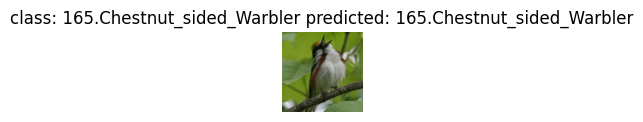

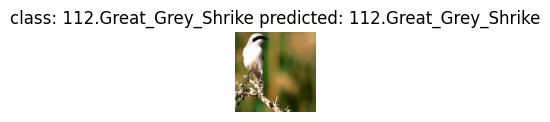

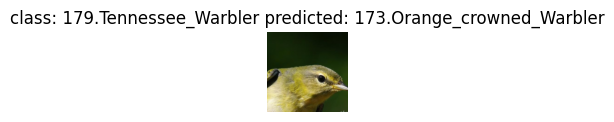

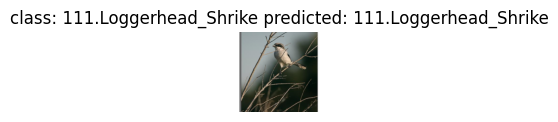

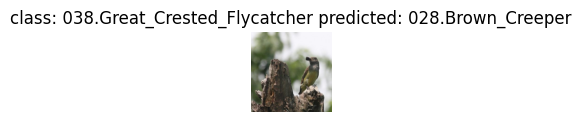

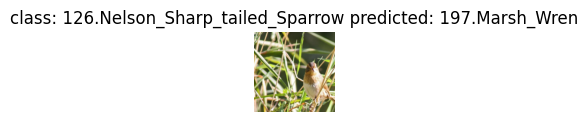

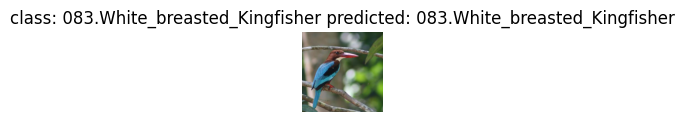

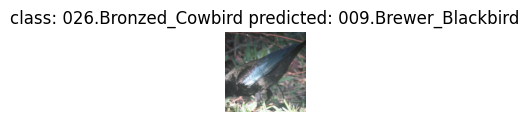

In [24]:
visualize_model(model)

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
